In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

In [3]:
trait_renaming = pd.read_csv(
    "../../results/gwas/raw/release1.1/UKBB_94traits_release1.traits", sep="\t",
).set_index("trait")["description"].to_dict()
trait_renaming = {}  # override
trait_renaming

{}

In [4]:
consequence_renaming = {
    "missense_variant": "missense",
    "non_coding_transcript_exon_variant": "ncRNA",
    "3_prime_UTR_variant": "3' UTR",
    "5_prime_UTR_variant": "5' UTR",
}

subset_renaming = {**trait_renaming, **consequence_renaming}

In [12]:
subsets = [
#    "all",

#    "nonexonic",
#    "missense_variant",
#    "non_coding_transcript_exon_variant",
#    "3_prime_UTR_variant",
#    "5_prime_UTR_variant",

#    "Height",
#    "MCV",
#    "MCH",
#    "Mono",
#    "Plt",
#    "eBMD",
#    "HbA1c",
#    "RBC",
#    "ALP",
#    "IGF1",
#    "HDLC",
#    "Eosino",
#    "LDLC",
#    "SHBG",
#    "AG",
#    "Lym",
#    "Hb",
#    "GGT",
#    "eGFRcys",
#    "ApoA",
#    "WBC",
#    "eGFR",
#    "TP",

    "traits_n50",
]

models = [
    "Enformer_L2+GPN-MSA+CADD",
    "Enformer_L2",
    "Borzoi_L2",
    "GPN-MSA",
    "CADD",
]

classifier = "LogisticRegression"

palette = {model: f"C{i}" for i, model in enumerate(models)}

dfs = []
sample_size = {}

base_dir = f"../../results/dataset/gwas_matched_9"
V = pd.read_parquet(f"{base_dir}/test.parquet")

for subset in tqdm(subsets):
    s = pd.read_parquet(f"{base_dir}/subset/{subset}.parquet")
    V_s = s.merge(V, on=["chrom", "pos", "ref", "alt"], how="left")
    sample_size[subset] = V_s.label.sum(), (~V_s.label).sum()
    for model in models:
        df = pd.read_csv(f"{base_dir}/metrics_by_chrom_weighted_average/{subset}/{model}.{classifier}.chrom.csv")
        df.Model = model
        df["subset"] = subset
        dfs.append(df)
df = pd.concat(dfs)
df

  0%|                                                                   | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


,Model,AUPRC,subset
0,Enformer_L2+GPN-MSA+CADD,0.346410,traits_n50
0,Enformer_L2,0.293855,traits_n50
0,Borzoi_L2,0.294104,traits_n50
0,GPN-MSA,0.249438,traits_n50
0,CADD,0.251060,traits_n50


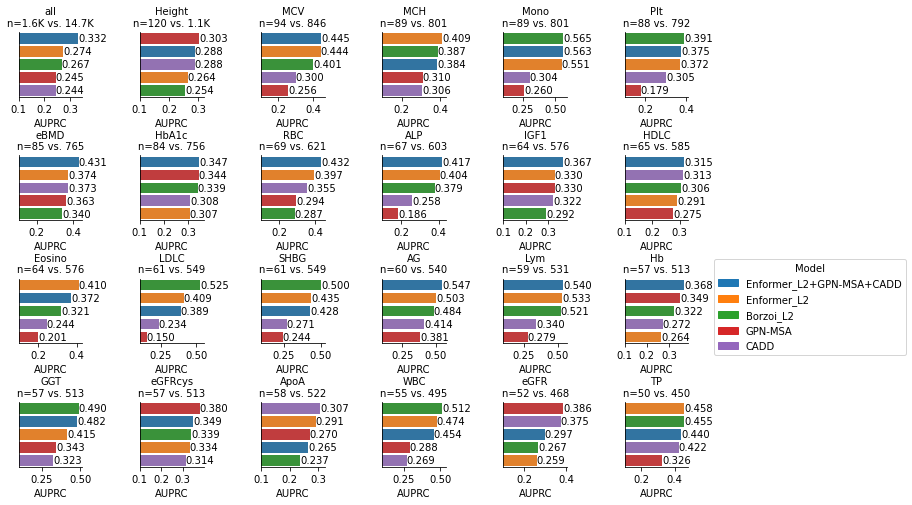

In [8]:
#nrows, ncols = 2, 3
nrows, ncols = 4, 6
width, height = 2, 2
wspace, hspace = 0.9, 0.9
metric = "AUPRC"

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=False, sharey=False,
    figsize=(width*ncols, height*nrows), squeeze=False,
    gridspec_kw={'wspace': wspace, 'hspace': hspace},
)

for subset, ax in zip(subsets, axes.flat):
    df_s = df[df.subset==subset].sort_values(metric, ascending=False)
    n_pos, n_neg = sample_size[subset]

    if metric == "AUROC":
        baseline = 0.5
    elif metric == "AUPRC":
        baseline = n_pos / (n_pos + n_neg)
    elif metric == "Odds ratio":
        baseline = 1

    g = sns.barplot(
        data=df_s,
        y="Model",
        x=metric,
        palette=palette,
        ax=ax,
    )
    sns.despine()
    sample_size_str = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    subtitle = f"{subset_renaming.get(subset, subset)}\n{sample_size_str}"
    g.set_title(subtitle, fontsize=10)
    g.set(
        xlim=baseline,
        ylabel="",
        yticks=[],
    )

    for bar, model in zip(g.patches, df_s.Model):
        text = f'{bar.get_width():.3f}'
        g.text(
            max(bar.get_width(), baseline),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            text,  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

plt.legend(
    handles=[mpatches.Patch(color=palette[model], label=model) for model in models],
    bbox_to_anchor=(1.4, 3.2),
    loc='upper left', borderaxespad=0.,
    title="Model",
)

In [9]:
df["n_pos"] = df.subset.apply(lambda x: sample_size[x][0])

def weighted_average(df):
    weights = df["n_pos"] / df["n_pos"].sum()
    return (df.AUPRC * weights).sum()

df_w = (
    df[df.subset!="all"].groupby("Model").apply(weighted_average).rename("AUPRC")
    .sort_values(ascending=False).to_frame().reset_index()
)
df_w

,Model,AUPRC
0,Enformer_L2+GPN-MSA+CADD,0.402273
1,Enformer_L2,0.386182
2,Borzoi_L2,0.383519
3,CADD,0.311857
4,GPN-MSA,0.288772


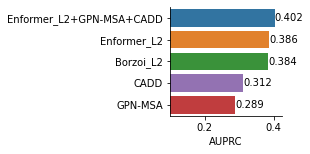

In [10]:
plt.figure(figsize=(2,2))
g = sns.barplot(
    data=df_w,
    y="Model",
    x="AUPRC",
    order=df_w.sort_values("AUPRC", ascending=False).Model,
    palette=palette,
)
for bar, model in zip(g.patches, df_w.Model):
    text = f'{bar.get_width():.3f}'
    g.text(
        max(bar.get_width(), baseline),  # X position, here at the end of the bar
        bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
        text,  # Text to be displayed, formatted to 3 decimal places
        va='center'  # Vertical alignment
    )
g.set(
    ylabel="",
    xlim=0.1,
)
sns.despine();

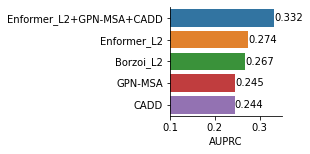

In [11]:
df_all = df[df.subset=="all"]

plt.figure(figsize=(2,2))
g = sns.barplot(
    data=df_all,
    y="Model",
    x="AUPRC",
    order=df_all.sort_values("AUPRC", ascending=False).Model,
    palette=palette,
)
for bar, model in zip(g.patches, df_all.Model):
    text = f'{bar.get_width():.3f}'
    g.text(
        max(bar.get_width(), baseline),  # X position, here at the end of the bar
        bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
        text,  # Text to be displayed, formatted to 3 decimal places
        va='center'  # Vertical alignment
    )
g.set(
    ylabel="",
    xlim=0.1,
)
sns.despine();

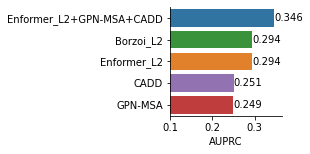

In [13]:
baseline = 0.1
plt.figure(figsize=(2,2))
g = sns.barplot(
    data=df,
    y="Model",
    x="AUPRC",
    order=df.sort_values("AUPRC", ascending=False).Model,
    palette=palette,
)
for bar, model in zip(g.patches, df.Model):
    text = f'{bar.get_width():.3f}'
    g.text(
        max(bar.get_width(), baseline),  # X position, here at the end of the bar
        bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
        text,  # Text to be displayed, formatted to 3 decimal places
        va='center'  # Vertical alignment
    )
g.set(
    ylabel="",
    xlim=0.1,
)
sns.despine();